In [3]:
import gensim
from gensim.utils import simple_preprocess
import pandas as pd
import spacy
RANDOM_STATE = 1

# 4. Advanced Techniques and Analysis
This section includes further text mining techniques: LDA for topic modeling and k-Means for clustering reviews. Similar to section 3, the machine learning models are trained and evaluated to assess their quality and effectiveness. 
## Latent Dirichlet Allocation (LDA)
LDA is a topic modeling algorithm that makes use of dimension reduction. Compared to T-SNE of section 2, LDA assumes that n latent topics are distributed randomly in each document where each topic is distinguished by a distribution of words [[8]](#8). \
For the LDA model, the rewiews are tokenized, punctuation is removed and the stop words of the stop word list are removed. Additionally tokens containing an apostrophe like "'ve" or "\'s" are removed which have high impact on the results. The LDA model results in 5 topics, and the first 10 top keywords of each topic are displayed below.


In [5]:
with open("StopWords.txt", "r") as f:
    stop_words = f.read().splitlines()

user_reviews = pd.read_csv("data/amazon.csv")

nlp = spacy.load("en_core_web_sm")

def tokenize(text: str, remove_punct=False):
    doc = nlp(text)
    tokens = [token.text for token in doc] if not remove_punct else [token.text for token in doc if not token.is_punct]
    return tokens

def remove_stopwords(tokens:list, stopword_list:list):
    tokens = set(tokens)
    stopwords = set(stopword_list)
    tokens.difference_update(stopwords)
    return list(tokens)

stop_words = stop_words + [" ", "n\'t", "\'s","\'ve", "\'m", "nt", "am"]

user_reviews["cleanedText"] = user_reviews.reviewText.str.lower().apply(tokenize, remove_punct=True).apply(remove_stopwords, stopword_list=stop_words)


In [62]:
import gensim.corpora as corpora

corpus = user_reviews["cleanedText"].tolist()
# Create Dictionary
id2word = corpora.Dictionary(corpus)

# Term Document Frequency
tf = [id2word.doc2bow(text) for text in corpus]
print(corpus[0])

['bunch', 'realustic', 'apps', 'eggs', 'acording', 'bombs', 'tnt', 'stuff', 'king', 'agree', 'pigs', 'people']


In [67]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=tf,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=RANDOM_STATE, alpha='auto', eta='auto')
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=10))
doc_lda = lda_model[tf]

[(0,
  '0.043*"app" + 0.034*"kindle" + 0.027*"fire" + 0.011*"phone" + 0.010*"love" '
  '+ 0.009*"free" + 0.008*"easy" + 0.007*"android" + 0.007*"apps" + '
  '0.006*"time"'),
 (1,
  '0.044*"app" + 0.013*"love" + 0.010*"day" + 0.009*"time" + 0.008*"alarm" + '
  '0.008*"free" + 0.007*"easy" + 0.006*"apps" + 0.005*"clock" + 0.005*"using"'),
 (2,
  '0.009*"app" + 0.008*"simple" + 0.005*"farm" + 0.005*"easy" + 0.005*"widget" '
  '+ 0.004*"setting" + 0.004*"flight" + 0.003*"love" + 0.003*"game" + '
  '0.003*"organized"'),
 (3,
  '0.045*"game" + 0.029*"app" + 0.023*"fun" + 0.018*"love" + 0.016*"time" + '
  '0.016*"play" + 0.010*"free" + 0.008*"games" + 0.008*"playing" + '
  '0.006*"people"'),
 (4,
  '0.030*"app" + 0.012*"easy" + 0.012*"love" + 0.008*"bible" + 0.008*"read" + '
  '0.006*"text" + 0.006*"keyboard" + 0.006*"apps" + 0.006*"google" + '
  '0.004*"able"')]


"App" is represented in every topic with a high weight. You also see "apps" in topic 0, 1 and 4 because no stemming was applied in the preprocessing step. Keywords in topic 4 suggests to be a topic about reading and books, since it includes "bible", "read" and "text". Topic 1 seems to be about an alarm / clock app, which we've already discussed in section 2 by exploring the T-SNE visualization. It is also difficult to extract meaningful topics from the top 10 keywords of each topic, especially because the topics have a large overlap. In further experiments the number of topics could be modified or the dictionary could be minimized by a specific POS-tag, e. g. only nouns are considered.

## k-Means Clustering
Clustering involves grouping similar data points together. K-means is a widely used clustering algorithm that partitions data into K clusters based on similarity. It is often applied in text analysis to discover patterns and group similar documents [[9]](#9). In this assignment, k-means is applied to cluster similar reviews by using BERT embeddings. To find an optimal k for the clustering algorithm, the elbow method is applied. The idea behind the elbow method is that one should choose a k that adding another cluster (k+1) doesn't give much better modelling of the data [[10]](10). To inspect this, k is plotted against the variance explained by the clusters.

c:\Users\jonas\anaconda3\envs\dm_ca2\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jonas\anaconda3\envs\dm_ca2\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jonas\anaconda3\envs\dm_ca2\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jonas\anaconda3\envs\dm_ca2\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will c

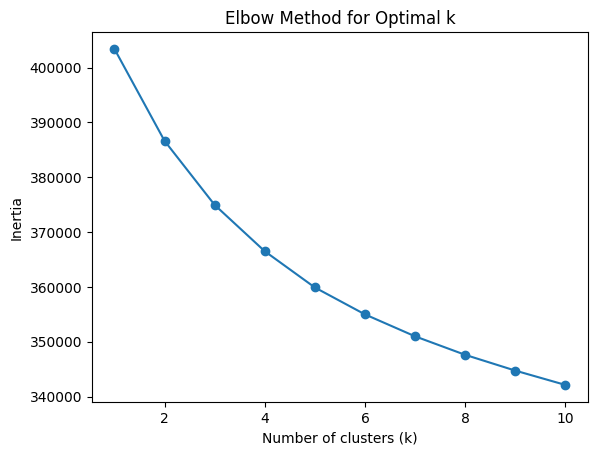

In [1]:
import pickle
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Load BERT embeddings from pickle file
with open('data/embeddings.pkl', 'rb') as f:
    bert_embeddings = pickle.load(f)

# Convert the list of embeddings to a numpy array
bert_embeddings_np = np.vstack(bert_embeddings.values)

# Specify the number of clusters (k) for k-means
k = 5  # Adjust this according to your requirements

inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bert_embeddings_np)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


The figure above shows that there is no optimal value of k, as the variance explained constantly decreases. Therefore we'll utilize the clustering algorithm with k=2 to investigate whether k-Means will distinguish between positive and negative reviews.

In [6]:
k = 2
# Initialize and fit the k-means model
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
kmeans.fit(bert_embeddings_np)

# Get cluster labels for each data point
user_reviews["cluster"] = kmeans.labels_
cluster_1 = user_reviews["cluster"] == 1
cluster_2 = user_reviews["cluster"] == 0
user_reviews.cluster.value_counts()

c:\Users\jonas\anaconda3\envs\dm_ca2\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


cluster
1    12620
0     7380
Name: count, dtype: int64

In [19]:
user_reviews[cluster_1].Positive.value_counts()

Positive
1    10625
0     1995
Name: count, dtype: int64

In [20]:
user_reviews[cluster_2].Positive.value_counts()

Positive
1    4608
0    2772
Name: count, dtype: int64

In [10]:
_ = user_reviews[cluster_1].reviewText[:10].apply(print)

This is a pretty good version of the game for being free. There are LOTS of different levels to play. My kids enjoy it a lot too.
this is a really cool game. there are a bunch of levels and you can find golden eggs. super fun.
This is a silly game and can be frustrating, but lots of fun and definitely recommend just as a fun time.
This is a very entertaining game!  You don't have to be smart to play it.  I guess that's why I like it...it's easy and fun and that's what games are suppose to be.  Be warned: this game is highly addictive.
this is awesome and you don't need wi ti to play trust me. it is really fun and addicting. there are like 100 levels it is even free don't waste your money on the expensive one I mean seriously. get the app
This is basicly the free version but with ads. That's actually awesome!!!! It's addicting and free at the same time really. I'd reccomend it.
this is by far the best free app that is available anywhere. it has helped pass the time when nothing else wou

In [17]:
_ = user_reviews[cluster_2].reviewText[:10].apply(print)

This is a one of the best apps acording to a bunch of people and I agree it has bombs eggs pigs TNT king pigs and realustic stuff
This is a terrific game on any pad. Hrs of fun.  My grandkids love it. Great entertainment when waiting in long lines
this is awesome I bet no one even reads the reviews because they know this game is so good that they don't need to
This is great! This is my tried & true game to cure boredom! Its great to try & get 3 stars on every level!
This is super fun though a little frustrating at times!!!!!!!!! I loved it before I got my kindle I would beg my brother and dad to play. But when I get it I play it all the time!!!!!!
this is the best app I ever downloaded for most of you people who say 1 2 3 or 4 stars you don't know much about what your supposed to do I purfor 5 stars for this app
THIS IS THE BESTEST GAME EVER OMG. IM SO EXCITED :TO PLAY OMG!!!!!!! OMG OMG OMG I LOVE ANGRY BIRDS SO MUCH ITS DA BOMB DIGGETY SO COOL OMG OMG OMG OMG OMG
this is the BEST gam

In [14]:
_ = user_reviews[cluster_2].reviewText[80:90].apply(print)

.I don't get why the birds angry.I don't get why everyone likes it. its not that fun of game.
i dont like it.  it stinks. it takes so much to make the stupid pigs die. they dont die quick enough. and the birds NEVER go where i want the to go. it is so frustrating that sometimes i want to throw my kindle across the room.  you can do better rovio. 
I don't like it so I say if you get it you are either so addicted you don't have a life or you got it for when there is almost nothing else to do or it is for a sinking or you are almost dead or you are dead oh ya also I just like posting random reviews
I don't under stand what the big deal is about this game my dad loves it and my brothers both like it but I don't under stand but whatever
I don't understand why this game is as popular as it is. I found it silly and boring. what is all the hype about?
I doundt think there should be a fee to use the mighty ehgle so I rate it a zero star ...... you
I guess you can tell by the title that I'm not 

Cluster 1 contains 12,620 instances, while cluster 2 contains 7,380. Cluster 1 has over 10,500 positive reviews and only 1,995 negative reviews, whereas cluster 2 has only 4,608 positive and 2,772 negative reviews so both clusters don't seem to distinguish very well in terms of sentiment. Next, we'll take a closer look at the reviews that has the widest and the closest distances to each cluster centre.

In [67]:
from sklearn.metrics import pairwise_distances_argmin_min

# Calculate distances between data points and cluster centers
distances = pairwise_distances_argmin_min(bert_embeddings_np, kmeans.cluster_centers_)[1]
# Round distances to 2 decimal places
distances = np.round(distances, 2)
# Add distances to your DataFrame (assuming you have one)
user_reviews['distance_to_cluster_center'] = distances

# Sort DataFrame by distance in descending order to find instances with widest distances
widest_distances_instances = user_reviews.sort_values(by='distance_to_cluster_center', ascending=False)

widest_distances_cluster_1 = widest_distances_instances.loc[cluster_1,['reviewText', 'distance_to_cluster_center', 'cluster', 'Positive']].head(3)
closest_distances_cluster_1 = widest_distances_instances.loc[cluster_1,['reviewText', 'distance_to_cluster_center', 'cluster', 'Positive']].tail(3)
widest_distances_cluster_2 = widest_distances_instances.loc[cluster_2,['reviewText', 'distance_to_cluster_center', 'cluster', 'Positive']].head(3)
closest_distances_cluster_2 = widest_distances_instances.loc[cluster_2,['reviewText', 'distance_to_cluster_center', 'cluster', 'Positive']].tail(3)
print("Cluster 1 widest:")
_ = widest_distances_cluster_1.apply(lambda x: print(x["reviewText"], x["distance_to_cluster_center"],"\n"), axis=1)
print("Cluster 1 closest:")
_ = closest_distances_cluster_1.apply(lambda x: print(x["reviewText"], x["distance_to_cluster_center"],"\n"), axis=1)
print("Cluster 2 widest:")
_ = widest_distances_cluster_2.apply(lambda x: print(x["reviewText"], x["distance_to_cluster_center"],"\n"), axis=1)
print("Cluster 2 closest:")
_ = closest_distances_cluster_2.apply(lambda x: print(x["reviewText"], x["distance_to_cluster_center"],"\n"), axis=1)


Cluster 1 widest:
free app free app first commentfree free free free free free free free free free free free free apppppppppppp of the day 8.92 

Uninstalled 7.82 

Remove app from Digital Device 7.64 

Cluster 1 closest:
I love this app! I like that I can write with my finger or type on the page if I choose. Since I type fast it would be great if the app wouldn't lag behind. I recommend this app for anyone who likes to keep notes or journals. I currently have this app ru 2.66 

This App is so worth the price.  Now I got mine on the Free App of the day however, I wouldn't mind paying for it.  This App is endless...by that I mean, you can use your own pictures to create a puzzle.  The App keeps track of your completion time and n 2.63 

Beautiful and full size pictures/puzzles on my tablet (running Honeycomb 3.2).  It is intuitive and easy to play.  I didn't get this app for excitement, but rather because I enjoy puzzles.  The developer didn't put in unnecessary permissions.  To top it 

Both clusters have as widest data points as widest data points, reviews that contain shorter texts and less information compared to the closest data points. The two closest data points to cluster 1 address a puzzle app. No patterns can be derived by the closest data points for second cluster centre.

<a id="8">[8]</a> Mohammed, Shaymaa & Al-augby, Salam. (2020). LSA & LDA Topic Modeling Classification: Comparison study on E-books. 2502-4752. 10.11591/ijeecs.v19.i1.pp%25p. \
<a id="9">[9]</a> MacQueen, J. (1967). Some Methods for Classification and Analysis of Multivariate Observations. Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability, 1, 281–297. \
<a id="10">[10]</a> Bholowalia, Purnima, and Arvind Kumar. "EBK-means: A clustering technique based on elbow method and k-means in WSN." International Journal of Computer Applications 105.9 (2014).